The goal of this notebook is to show that the temporal aspect can be leveraged in a better way. 
Specifically, we want to show that if we consider two opposite causal directions, when we start conditioning on markov blanket members, one of the two directions mutual information will start to decrease, while the other one will keep stable (if not increase). 

In [1]:
N_VARS = 5
NOISE_STD = 0.1
MAXLAGS = 4
N_JOBS = 40

In [2]:
import networkx as nx
from d2c.data_generation.utils import show_DAG
from d2c.descriptors import D2C, DataLoader

## Data Generation
We start by generating some data and we save it. 
(You can load it from the file directly)

In [3]:
# from d2c.data_generation import TSBuilder

# # we generate 720 dags (20 per process)
# tsbuilder = TSBuilder(observations_per_time_series=250, 
#                         maxlags=MAXLAGS, 
#                         n_variables=N_VARS, 
#                         time_series_per_process=40, 
#                         processes_to_use=[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20], 
#                         noise_std=NOISE_STD, 
#                         max_neighborhood_size=2, 
#                         seed=42, 
#                         max_attempts=20,
#                         verbose=False)

# tsbuilder.build()
# tsbuilder.to_pickle('/home/gpaldino/data.pkl')



In [4]:
dataloader = DataLoader(n_variables = N_VARS,
                    maxlags = MAXLAGS)
# dataloader.from_tsbuilder(tsbuilder)
dataloader.from_pickle('/home/gpaldino/data.pkl')


original_observations = dataloader.get_original_observations()
lagged_flattened_observations = dataloader.get_observations()
flattened_dags = dataloader.get_dags()

## Useful functions
We now write a function to get the true markov blanket of a variable in a specified dag

In [5]:
def return_mb(dag, variable_name, subset=None):
    parents = list(dag.predecessors(variable_name))
    children = list(dag.successors(variable_name))
    spouses = [list(dag.predecessors(child)) for child in children]
    spouses = [item for sublist in spouses for item in sublist]
    if subset is None:
        mb = set(parents + children + spouses)
    elif subset == 'parents':
        mb = set(parents)
    elif subset == 'children':
        mb = set(children)
    elif subset == 'spouses':
        mb = set(spouses)
    if variable_name in mb:
        mb.remove(variable_name)
    return list(mb)


## The idea
Let's consider the first DAG

In [6]:
one_obs = original_observations[0]
one_lagged_obs = lagged_flattened_observations[0]
one_dag = flattened_dags[0]

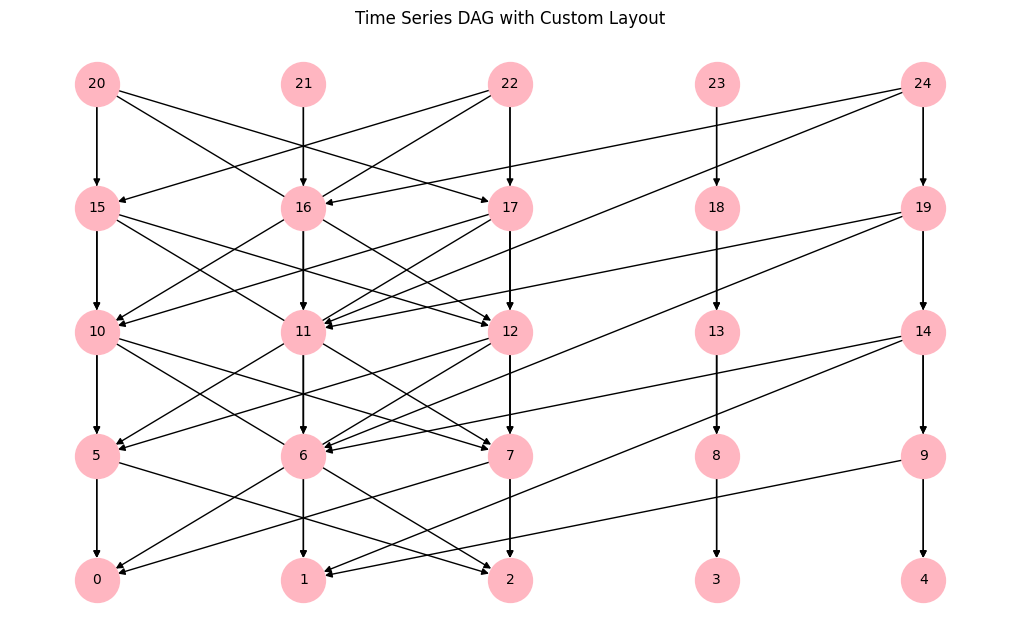

In [7]:
show_DAG(one_dag, N_VARS, MAXLAGS)

Let's consider on the first two variables and in particular on the causal relationship between variable 0 and variable 1. <br> 
We can see from the DAG that 1 --> 0 but 0 -/->1. Now if we focus specifically on lagged couples 11 --> 5 and 10 -/->6, we should be able to show the following: <br>

$I(11,5 | x)$ will not decrease by increasing the conditioning set <br>
$I(10,6 | x)$ will decrease by increasing the conditioning set <br>


## First experiment: conditioning only on the parent of the effect 
We condition on the antecedent of the presumed effect, i.e., if you test x(t-1) -> y(t) conditioning on y(t-1) should not decrease I(x(t-1);y(t)| y(t-1)) relative to I(x(t-1);y(t)) if the causal link exists 

As a Mutual Information estimator we adopt CMIknn 

In [8]:
# ! git clone https://github.com/omesner/knncmi.git
# ! cd knncmi && pip install .
# ! cd ..
# ! rm -rf knncmi

# we won't compute the full descriptors set but we still need the estimators for Mutual Information
from d2c.descriptors.estimators import MutualInformationEstimator
mutual_information_estimator = MutualInformationEstimator() # default: estimator using Ridge
# cmi = mutual_information_estimator.estimate_original
cmi = mutual_information_estimator.estimate_knn_cmi


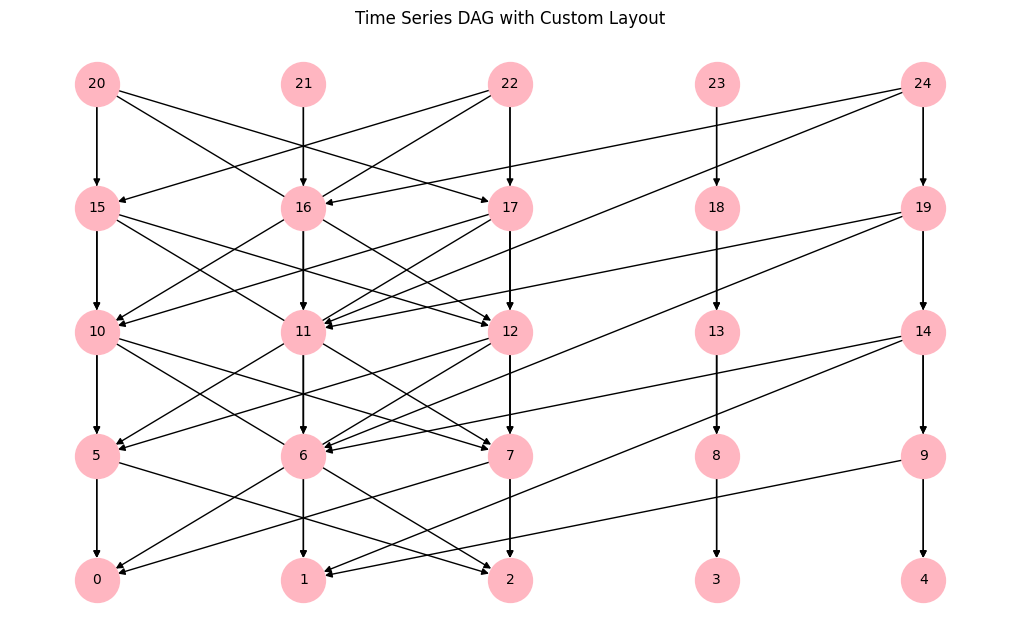

In [9]:
show_DAG(one_dag, N_VARS, MAXLAGS)

In [10]:
one_dag.edges

OutEdgeView([(20, 15), (20, 17), (20, 10), (20, 12), (21, 16), (21, 11), (22, 15), (22, 17), (22, 10), (22, 12), (23, 18), (23, 13), (24, 16), (24, 19), (24, 11), (24, 14), (15, 10), (15, 12), (15, 5), (15, 7), (16, 11), (16, 6), (17, 10), (17, 12), (17, 5), (17, 7), (18, 13), (18, 8), (19, 11), (19, 14), (19, 6), (19, 9), (10, 5), (10, 7), (10, 0), (10, 2), (11, 6), (11, 1), (12, 5), (12, 7), (12, 0), (12, 2), (13, 8), (13, 3), (14, 6), (14, 9), (14, 1), (14, 4), (5, 0), (5, 2), (6, 1), (7, 0), (7, 2), (8, 3), (9, 1), (9, 4)])

In [11]:
one_lagged_obs.shape

(246, 25)

In [13]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import itertools

# Function to compute delta for causal and non-causal edges
def compute_deltas(position_index):
    verbose = False  # Set to True if you want to print verbose output
    deltas_causal = []
    deltas_noncausal = []

    one_obs = original_observations[position_index]
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        if verbose:
            print(f"Edge {source} -> {target}")

        # Compute deltas for causal edge
        parent_of_putative_effect = target + N_VARS
        if parent_of_putative_effect < N_VARS * (MAXLAGS + 1):
            before_causal = cmi(one_lagged_obs, source, target)
            after_causal = cmi(one_lagged_obs, source, target, [parent_of_putative_effect])

        if verbose:
            print(f"Opposite edge {opposite_source} -> {opposite_target}")

        # Compute deltas for non-causal edge
        parent_of_putative_effect = opposite_target + N_VARS
        if parent_of_putative_effect < N_VARS * (MAXLAGS + 1):
            before_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target)
            after_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target, [parent_of_putative_effect])

        deltas_causal.append(before_causal - before_noncausal)
        deltas_noncausal.append(after_causal - after_noncausal)
    return deltas_causal, deltas_noncausal

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_deltas, range(len(original_observations))), total=len(original_observations)))

    # Unpack results
    deltas_causal = []
    deltas_noncausal = []
    for result in results:
        deltas_causal.extend(result[0])
        deltas_noncausal.extend(result[1])

    # Now deltas_causal and deltas_noncausal contain the computed deltas from all processes

    # Example of how to pickle the deltas
    import pickle
    with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "wb") as f:
        pickle.dump((deltas_causal, deltas_noncausal), f)


100%|██████████| 720/720 [01:05<00:00, 10.97it/s]


In [ ]:
# from tqdm import tqdm

# # only the parent of the putative effect 
# verbose = False 
# deltas_causal = []
# deltas_noncausal = []

# for position_index in tqdm(range(len(original_observations)), total=len(original_observations)):
    
#     one_obs = original_observations[position_index]
#     one_lagged_obs = lagged_flattened_observations[position_index]
#     one_dag = flattened_dags[position_index]

#     for edge in one_dag.edges:
#         source, target = edge
#         if (source - target) % N_VARS == 0:
#             continue # parent -> child of the same variable 

#         opposite_source = target + N_VARS
#         opposite_target = source - N_VARS

#         if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
#             continue

#         if verbose: print(f"Edge {source} -> {target}")


#         # I(source, target | x)
#         parent_of_putative_effect = target + N_VARS 
#         if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
#             continue
#         before_causal = cmi(one_lagged_obs, source, target)
#         after_causal = cmi(one_lagged_obs, source, target, [parent_of_putative_effect])
#         delta_causal = before_causal - after_causal

#         deltas_causal.append(delta_causal)

#         if verbose: print(f"Opposite edge {opposite_source} -> {opposite_target}")

#         # I(opposite_source, opposite_target | x)
#         parent_of_putative_effect = opposite_target + N_VARS 
#         if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
#             continue
#         before_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target)
#         after_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target, [parent_of_putative_effect])
#         delta_noncausal = before_noncausal - after_noncausal

#         deltas_noncausal.append(delta_noncausal)

# # # pickle the deltas
# # import pickle
# # with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "wb") as f:
# #     pickle.dump((deltas_causal,deltas_noncausal), f)



In [14]:
# load the deltas
import pickle
with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "rb") as f:
    deltas_causal,deltas_noncausal = pickle.load(f)


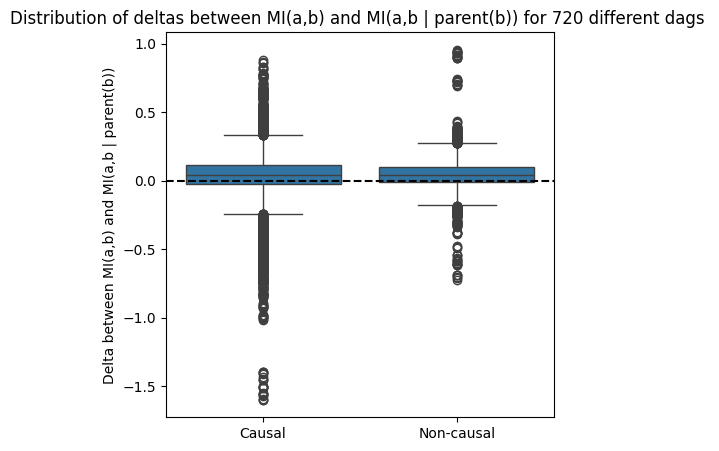

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# Combine the data into a single list or array
all_deltas = deltas_causal + deltas_noncausal
labels = ['Causal'] * len(deltas_causal) + ['Non-causal'] * len(deltas_noncausal)

# Create boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x=labels, y=all_deltas)
# line at 0
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Delta between MI(a,b) and MI(a,b | parent(b))')
plt.title('Distribution of deltas between MI(a,b) and MI(a,b | parent(b)) for 720 different dags ')
plt.show()

In [125]:
from scipy import stats

# Perform t-test
t_statistic, p_value = stats.ttest_ind(deltas_causal, deltas_noncausal)

# Print results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between the groups.")

T-statistic: -6.05110940899652
P-value: 1.4659786980816436e-09
Reject null hypothesis: There is a significant difference between the groups.


## Second experiment: conditioning on all the true parents and assessing how the mutual information changes

In [19]:
def compute_mis(one_lagged_obs, source, target, subset, verbose, only_target=False):
    """
    Computes the mutual information score (MIS) between a source and target node,
    conditioned on subsets of their Markov blankets (MBs).
    Parameters:
    source (int or str): The source node.
    target (int or str): The target node.
    subset (list): A subset of nodes to consider for the Markov blanket (only parents; only children; only spouses).
    verbose (bool): If True, prints detailed debug information.
    Returns:
    dict: A dictionary where keys are the size of the conditioning set and values
          are the corresponding conditional mutual information scores.
    """
    # I(source, target | x)
    if verbose: print(f"Edge {source} -> {target}")

    mb_source = return_mb(one_dag, source, subset=subset)
    if verbose: print(f'MB Souce {mb_source}')

    mb_target = return_mb(one_dag, target, subset=subset)
    if verbose: print(f'MB Target {mb_target}')

    if only_target:
        combined_mbs = list(set(mb_target) - {source, target}) # target parents only
    else:
        combined_mbs = list(set(mb_source + mb_target) - {source, target})


    if verbose: print(f'MB Combined {combined_mbs}')

    mutual_information_causal = {}

    single_mi = cmi(one_lagged_obs, source, target)
    if verbose: print(f'Not conditioning: {single_mi}')

    for m_idx in range(1,len(combined_mbs)+1):
        m = combined_mbs[:m_idx]
        single_mi = cmi(one_lagged_obs, source, target, m)
        if verbose: print(f'Conditioning on {m}: {single_mi}')
        mutual_information_causal[m_idx] = single_mi
    return single_mi, mutual_information_causal



In [20]:
# PARALLEL VERSION (sequential below)

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

verbose = False
SUBSET = 'parents'
mi_dags = {}

# Function to compute mi_dags for a single position_index
def compute_mi_dag(position_index):
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    mi_single_dag = {}
    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        # Compute mutual information for both directions synchronously
        single_mi_direction_one, mi_direction_one = compute_mis(one_lagged_obs, source, target, SUBSET, verbose, only_target=True)
        single_mi_direction_two, mi_direction_two = compute_mis(one_lagged_obs, opposite_source, opposite_target, SUBSET, verbose)

        mi_single_dag[(source, target)] = (single_mi_direction_one, mi_direction_one, single_mi_direction_two, mi_direction_two)

    return mi_single_dag

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_mi_dag, range(len(original_observations))), total=len(original_observations)))

    # Gather results into mi_dags
    for position_index, result in enumerate(results):
        mi_dags[position_index] = result

    # Now mi_dags contains the computed mutual informations for all position indices


100%|██████████| 720/720 [02:27<00:00,  4.87it/s]


In [ ]:
## SEQUENTIAL VERSION (sequential below)
# verbose = False 
# SUBSET = 'parents'
# mi_dags = {}
# for position_index in tqdm(range(len(original_observations)), total=len(original_observations)):
#     one_obs = original_observations[position_index]
#     one_lagged_obs = lagged_flattened_observations[position_index]
#     one_dag = flattened_dags[position_index]

#     mi_single_dag = {}
#     for edge in one_dag.edges:
#         source, target = edge
#         if (source - target) % N_VARS == 0:
#             continue # parent -> child of the same variable 

#         opposite_source = target + N_VARS
#         opposite_target = source - N_VARS

#         if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
#             continue

#         mi_direction_one = compute_mis(one_lagged_obs,source, target, SUBSET, verbose)
#         mi_direction_two = compute_mis(one_lagged_obs,opposite_source, opposite_target, SUBSET, verbose)

#         mi_single_dag[(source, target)] = (mi_direction_one, mi_direction_two)

#     mi_dags[position_index] = mi_single_dag

In [137]:
flattened_dags[0].edges

OutEdgeView([(20, 15), (20, 17), (20, 10), (20, 12), (21, 16), (21, 11), (22, 15), (22, 17), (22, 10), (22, 12), (23, 18), (23, 13), (24, 16), (24, 19), (24, 11), (24, 14), (15, 10), (15, 12), (15, 5), (15, 7), (16, 11), (16, 6), (17, 10), (17, 12), (17, 5), (17, 7), (18, 13), (18, 8), (19, 11), (19, 14), (19, 6), (19, 9), (10, 5), (10, 7), (10, 0), (10, 2), (11, 6), (11, 1), (12, 5), (12, 7), (12, 0), (12, 2), (13, 8), (13, 3), (14, 6), (14, 9), (14, 1), (14, 4), (5, 0), (5, 2), (6, 1), (7, 0), (7, 2), (8, 3), (9, 1), (9, 4)])

In [27]:
mi_dags[0][(20,17)]

(0.11833529015273894,
 {1: 0.11833529015273894},
 0.12192162674952686,
 {1: 0.12192162674952686})

In [30]:
noncausal_changes

{1: 0.8806912515218341, 2: 0.8469200765627876}

In [31]:
causal_deltas_single_dag = {}
noncausal_deltas_single_dag = {}
for _, mi_dag in mi_dags.items():
    for pair, elements in mi_dag.items():
        causal_before = elements[0]
        causal_changes = elements[1]
        noncausal_before = elements[2]
        noncausal_changes = elements[3]

        causal_deltas_single_couple = {}
        if 0 in causal_deltas_single_dag:
            causal_deltas_single_dag[0].append(causal_before - noncausal_before)
        else:
            causal_deltas_single_dag[0] = [causal_before - noncausal_before]
            
        for key, causal_value in causal_changes.items():
            if key in noncausal_changes:
                noncausal_value = noncausal_changes[key]
                if key in causal_deltas_single_dag:
                    causal_deltas_single_dag[key].append(causal_value - noncausal_value)
                else:
                    causal_deltas_single_dag[key] = [causal_value - noncausal_value]


            


In [33]:
causal_deltas_single_dag.keys()

dict_keys([0, 1, 2, 3, 4])

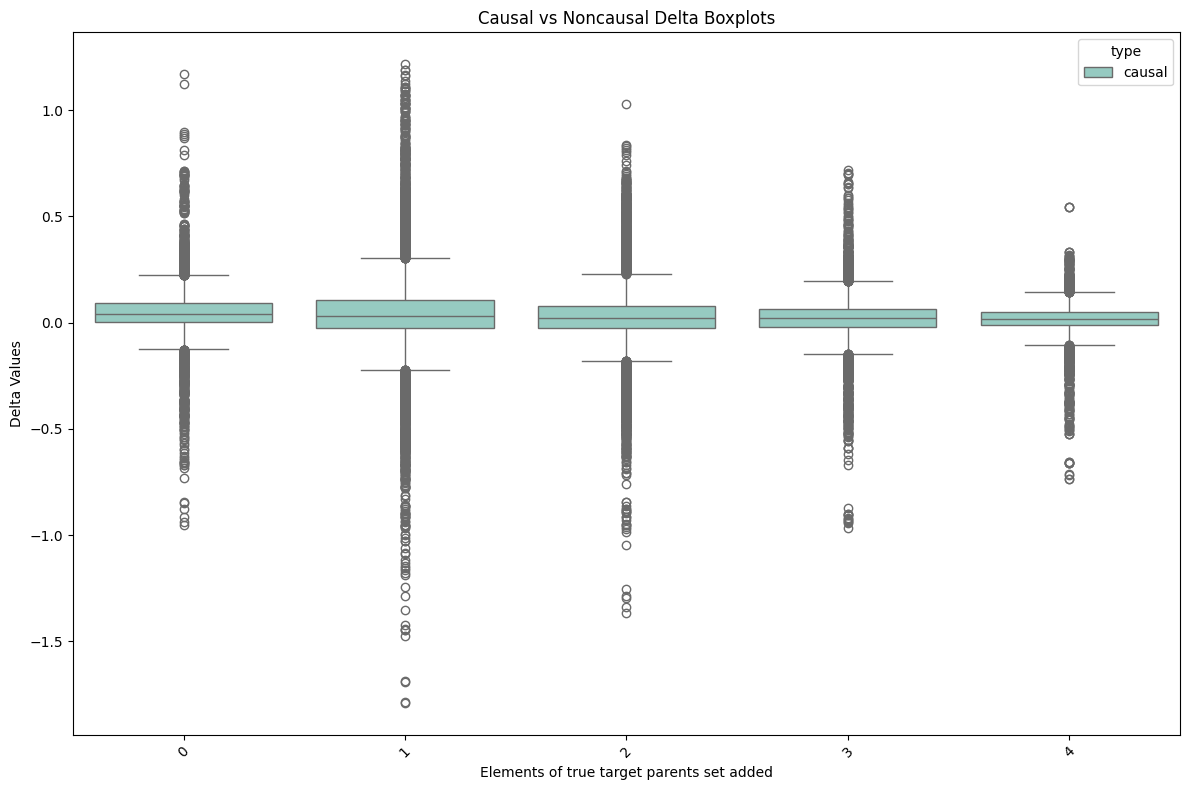

In [35]:
import pandas as pd
# Prepare data for boxplot
data = []
keys = set(causal_deltas_single_dag.keys()).union(set(noncausal_deltas_single_dag.keys()))

for key in keys:
    if key in causal_deltas_single_dag:
        for causal_val in causal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val
            })
    elif key in causal_deltas_single_dag:
        for causal_val in causal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting boxplots
plt.figure(figsize=(12, 8))
plt.title('Causal vs Noncausal Delta Boxplots')

# Boxplot using seaborn
import seaborn as sns
sns.boxplot(x='key', y='value', hue='type', data=df, palette='Set3')
plt.xlabel('Elements of true target parents set added')
plt.ylabel('Delta Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

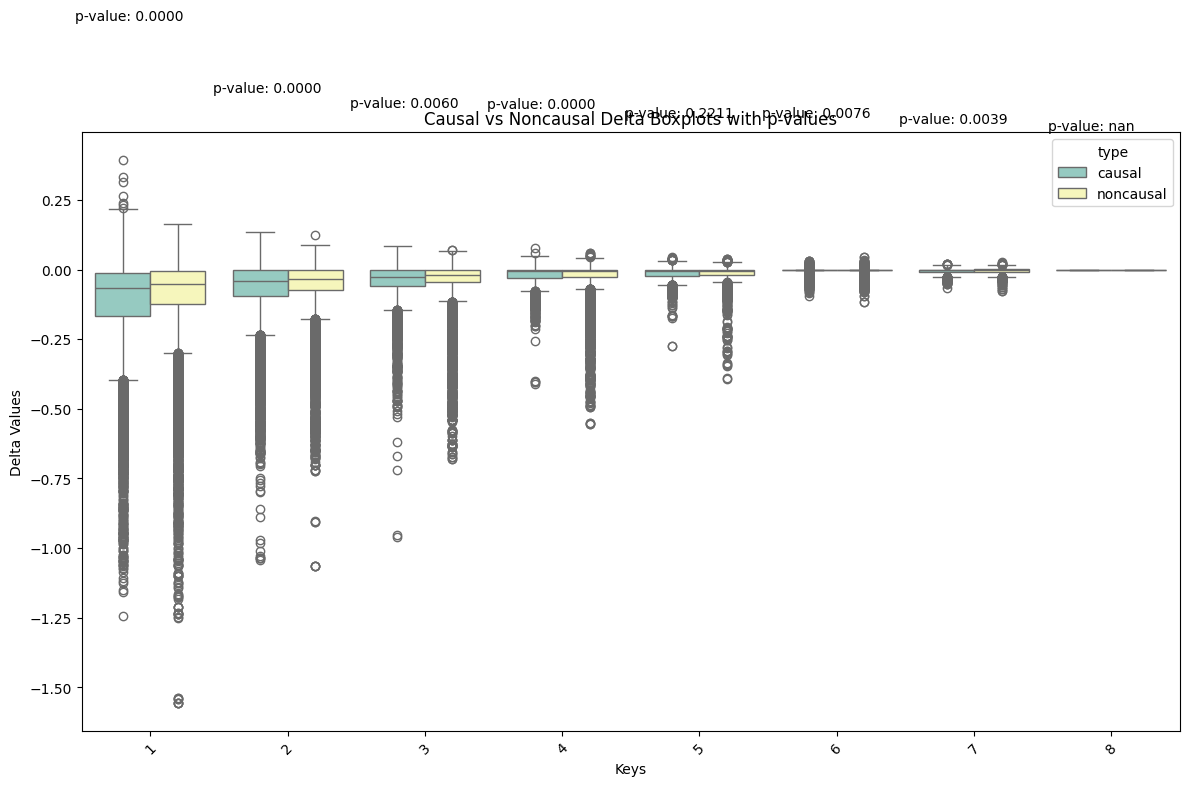

In [162]:
from scipy.stats import ttest_ind


# Prepare data for boxplot and calculate p-values
data = []
keys = set(causal_deltas_single_dag.keys()).union(set(noncausal_deltas_single_dag.keys()))

for key in keys:
    if key in causal_deltas_single_dag and key in noncausal_deltas_single_dag:
        for causal_val, noncausal_val in zip(causal_deltas_single_dag[key], noncausal_deltas_single_dag[key]):
            t_stat, p_val = ttest_ind(causal_deltas_single_dag[key], noncausal_deltas_single_dag[key])
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val,
                'p_value': p_val
            })
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val,
                'p_value': p_val
            })
    elif key in causal_deltas_single_dag:
        for causal_val in causal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val,
                'p_value': None  # No p-value for single data points
            })
    elif key in noncausal_deltas_single_dag:
        for noncausal_val in noncausal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val,
                'p_value': None  # No p-value for single data points
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting boxplots
plt.figure(figsize=(12, 8))
plt.title('Causal vs Noncausal Delta Boxplots with p-values')

# Boxplot using seaborn
import seaborn as sns
sns.boxplot(x='key', y='value', hue='type', data=df, palette='Set3')

# Annotate with p-values
for key in keys:
    causal_vals = df[(df['key'] == key) & (df['type'] == 'causal')]['value'].values
    noncausal_vals = df[(df['key'] == key) & (df['type'] == 'noncausal')]['value'].values
    p_val = df[(df['key'] == key) & (df['type'] == 'causal')]['p_value'].values[0]  # Assume p-value is the same for both causal and noncausal
    
    if p_val is not None:
        plt.text(list(keys).index(key) - 0.15, max(max(causal_vals), max(noncausal_vals)) + 0.5, f'p-value: {p_val:.4f}', fontsize=10, ha='center')

plt.xlabel('Keys')
plt.ylabel('Delta Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Experiment 3: using whole markov blanket of the target variable 

In [ ]:
# PARALLEL VERSION (sequential below)

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

verbose = False
SUBSET = 'parents'
mi_dags = {}

# Function to compute mi_dags for a single position_index
def compute_mi_dag(position_index):
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    mi_single_dag = {}
    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        # Compute mutual information for both directions synchronously
        single_mi_direction_one, mi_direction_one = compute_mis(one_lagged_obs, source, target, SUBSET, verbose)
        single_mi_direction_two, mi_direction_two = compute_mis(one_lagged_obs, opposite_source, opposite_target, SUBSET, verbose)

        mi_single_dag[(source, target)] = (single_mi_direction_one, mi_direction_one, single_mi_direction_two, mi_direction_two)

    return mi_single_dag

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_mi_dag, range(len(original_observations))), total=len(original_observations)))

    # Gather results into mi_dags
    for position_index, result in enumerate(results):
        mi_dags[position_index] = result

    # Now mi_dags contains the computed mutual informations for all position indices
